In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support,classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

In [2]:
def remove_stopwords(x_train):
    return np.array( [' '.join([word for word in sample.split() if word.lower() not in stop]) for sample in x_train])

def build_pipeline(classifier_fn,x_train,y_train):
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2),max_df=0.5)),
        ('tfidf_transformer',  TfidfTransformer()),
        ('classifier',          classifier_fn)
        ])
    pipeline.fit(x_train,y_train)
    return pipeline

def plot_confusion_matrix(y_test,y_predicted,labels):
    cm = confusion_matrix(y_test, y_predicted,labels =list(labels))

    figsize = (10,7)
    df_cm = pd.DataFrame(
        cm, index=set(y_test), columns=set(y_test), 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def evaluate_classifier(pipeline, x_test, y_test):
    y_predicted = pipeline.predict(x_test)
    report  = classification_report(y_test, y_predicted)
    print(report)
    plot_confusion_matrix(y_test, y_predicted, set(y_test))

In [3]:
data = pd.read_csv('../Data/labelled.csv',index_col='displayLink')
data = data.loc[~data['snippet'].isnull()]
data = data[(data['first'].isin(['purchase']))  & ((data['drug'].isin(['cocaine','mdma'])))]

In [4]:
labelled = data[~data.label.isnull()]
labelled.loc[labelled.label == 2, 'label'] = 1.0
unlabelled = data[data.label.isnull()]
unlabelled = unlabelled.drop(['first','drug','label'], axis=1)

/Users/mike/miniconda3/envs/esc/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
train_data, test_data = train_test_split(labelled, test_size=0.2, random_state= 42)

In [6]:
print('training') 
print(train_data.label.value_counts())
print('testing')
print(test_data.label.value_counts())

training
1.0    33
0.0    14
Name: label, dtype: int64
testing
1.0    9
0.0    3
Name: label, dtype: int64


In [7]:
x_train = train_data['snippet'].values
y_train = train_data['label'].values
x_test = test_data['snippet'].values
y_test = test_data['label'].values
x_pred = unlabelled['snippet'].values

In [8]:
stop = stopwords.words('english')
x_train_nostop = remove_stopwords(x_train)
x_test_no_stop = remove_stopwords(x_test)
x_pred_no_stop = remove_stopwords(x_pred)

In [9]:
#pipeline = build_pipeline(MultinomialNB(),x_train_nostop,y_train)
#evaluate_classifier(pipeline, x_test_no_stop, y_test)

/Users/mike/miniconda3/envs/esc/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/Users/mike/miniconda3/envs/esc/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mike/miniconda3/envs/esc/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mike/miniconda3/envs/esc

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.75      1.00      0.86         9

   micro avg       0.75      0.75      0.75        12
   macro avg       0.38      0.50      0.43        12
weighted avg       0.56      0.75      0.64        12



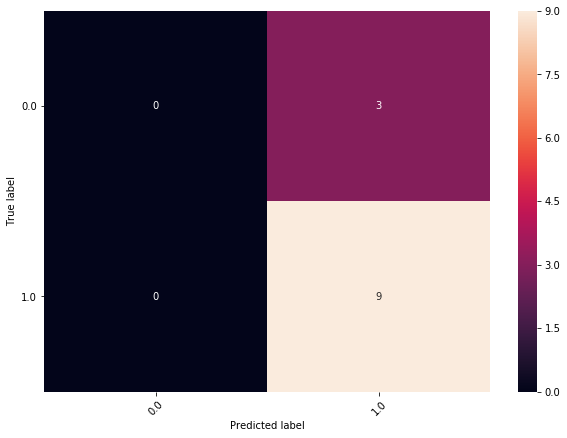

In [14]:
pipeline = build_pipeline(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None),x_train_nostop,y_train)
evaluate_classifier(pipeline, x_test_no_stop, y_test)

In [15]:
unlabelled["prediction"] = pipeline.predict(x_pred_no_stop)

In [16]:
unlabelled[unlabelled.prediction == 1.0].head(10)

,snippet,count,prediction
displayLink,,,
www.chemistryorg.com,"Now, let's take one research chemical as an ex...",95,1.0
www.miobambino.it,"Dec 11, 2017 ... nowahbayani1, Buy cocaine onl...",94,1.0
greencoloradodragon420.com,Buy Powdered cocaine for sale online - greenco...,92,1.0
www.buymdmaonline.com,MDMA Powder Archives - BUY MDMA Online,92,1.0
pharmacycanadian-discount.net,Ecstasy 100mg MDMA Online | cheap prices witho...,91,1.0
www.drharrisonclinic.com,Buy Cocaine Online | Crack For Sell Online | B...,90,1.0
www.roaconsulting.co.kr,"Purchase MDMA 100% Satisfaction Guarantee, Bes...",89,1.0
buycocaineonlineusa.com,buy pure cocaine online Archives - Buy Cocaine...,87,1.0
www.buymedsonlinestore.com,MDMA for Sale Online USA | Pure MDMA Online - ...,86,1.0


In [17]:
unlabelled[unlabelled.prediction == 0.0].head(20)

,snippet,count,prediction
displayLink,,,
www.plantfeedshop.com,Items 1 - 15 of 18 ... Buy Mephedrone plant fo...,88,0.0
us.christianlouboutin.com,Visit Our Official Online Store in United Stat...,87,0.0
www.freepennysaver.com,Free Pennysaver Online Classified Ads : Find : :,51,0.0
store.unionlosangeles.com,"Aug 9, 2017 ... 100% cotton custom knitted jer...",35,0.0
purchaseonlinelsdstore.net,"Jan 2, 2017 ... Lysergic Acid Diethylamide abb...",34,0.0
e4sc.org,FDA approved Health product! Need a product th...,18,0.0
bunkpolice.com,"Feb 9, 2018 ... In order to detect quite liter...",16,0.0
photo-bievre.org,"Where to purchase tramadol online - Pill Shop,...",13,0.0
www.mdinaglass.com.mt,Mdina Glass Malta are a leading Glass Maker in...,11,0.0
